In [2]:
# widen cells to be 95 % of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib.pyplot as plt
from PIL import Image
import cv2

# General 
## DiT: Self-Supervised Pre-Training for Document Image Transformer

### Paper
https://arxiv.org/pdf/2203.02378v1.pdf

### The architecture & fine-tuned model wheights are available
https://huggingface.co/microsoft/dit-base-finetuned-rvlcdip

### Repository for base- and fine-tuned models
https://github.com/microsoft/unilm/tree/master/dit



# Pre-Training

## Dataset

IIT-CDIP - https://dl.acm.org/doi/10.1145/1148170.1148307 - [Free Access] https://ir.cs.georgetown.edu/downloads/sigir06cdipcoll_v05-with-authors.pdf

**Soley images from the tabacco industry: 
42 million images with ~1.5 Terrabyte of data**

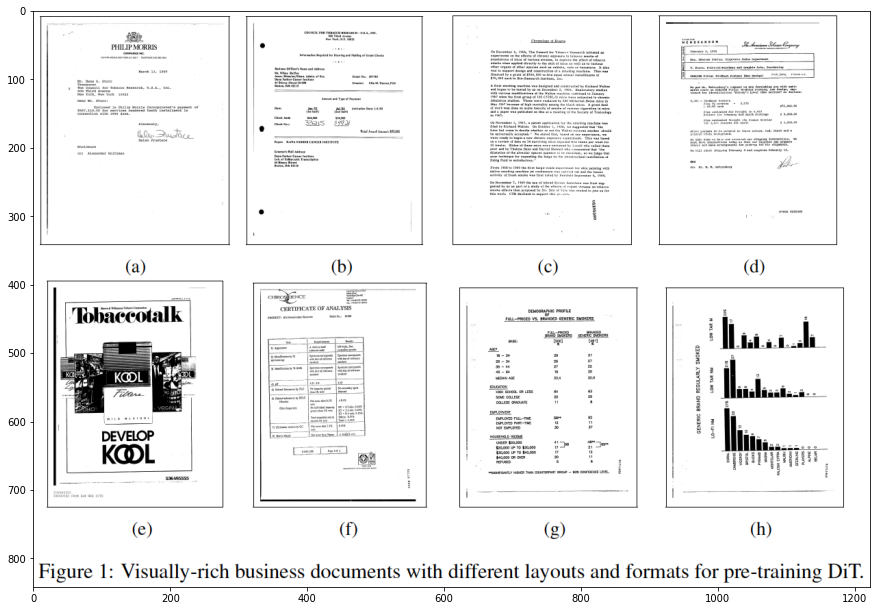

In [3]:
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Image.open('./presentation_images/sample_image_pre.png').convert('RGB'))

## Inputs

**Shape [224 x 224 x 3]**

## Architecture

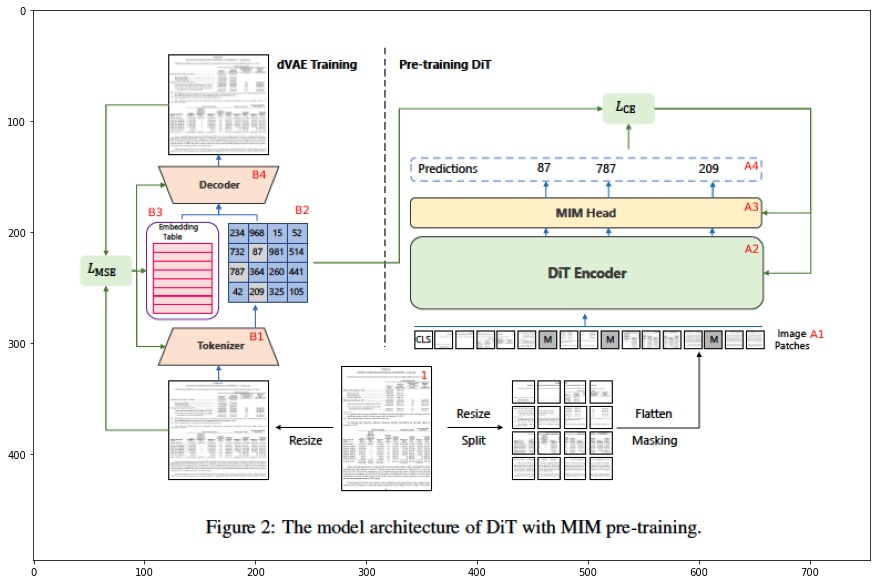

In [4]:
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Image.open('./presentation_images/base_pre_training.png').convert('RGB'))

### Comparison to BEiT

In [ ]:
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Image.open('./presentation_images/beit_architecture_pre_training.png').convert('RGB'))

# Necessary Code and Imports

In [ ]:
# general
import pandas as pd 
import numpy as np 
import os
from pathlib import Path
import time 

# stats
from sklearn import preprocessing as sk_pre

# torch
import torch
from torchinfo import summary

# architectures
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, BeitForMaskedImageModeling, AutoModel 

# plotting
import matplotlib.pyplot as plt 
import seaborn as sn
sn.set_theme(palette="colorblind",)
sn.set_style(style='white')

# image processing 
from PIL import Image
import cv2

In [ ]:
#########
# GLOBALS
#########
PATH_BASE = Path(os.path.abspath(''))
PATH_IMAGE_FOLDERS = PATH_BASE / '../dataset/rvl-cdip/images'
PATH_IMAGE_LABELS = PATH_BASE / '../dataset/rvl-cdip/labels'

M_CLASS_COUNT = 16
M_CLASS_LABELS = (
    'letter', 'form', 'email', 'handwritten', 
    'advertisement', 'scientific report', 
    'scientific' 'publication', 'specification', 
    'file folder', 'news article', 'budget', 
    'invoice', 'presentation', 'questionnaire', 
    'resume', 'memog'
)

HUB_PATH_BASE_MODEL = "microsoft/dit-base"
HUB_PATH_CLASSIFICATION_FT = HUB_PATH_BASE_MODEL + "-finetuned-rvlcdip"

FEATURE_EXTRACTOR_CLASSIFICATION_FT = AutoFeatureExtractor.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")
#MODEL_BASE = 
MODEL_CLASSIFICATION_FT = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")




#########
# METHODS
#########

def norm_to_range(arr: list = None, certain_max: int = None, certain_min: int = None) -> list:
    """Min-Max normalization with the option to pass certain mins an maxes"""
    if arr is None: 
        return ValueError("A list of None can not be normalized.")
    
    if certain_min is None: 
        mi = np.min(arr)
        
        # both none
        if certain_max is None: 
            return np.array((arr - mi) / (np.max(arr) - mi))
        
        # max not none
        return np.array((arr - mi) / (certain_max - mi))
    else:
        # bot not none
        if certain_max is None: 
            return np.array((arr - certain_min) / (certain_max - certain_min))
        
    return np.array((arr - certain_min) / (np.max(arr) - certain_min))
       
    
def inferre_model(im: Image = None, ex = FEATURE_EXTRACTOR_CLASSIFICATION_FT, mo = MODEL_CLASSIFICATION_FT) -> str: 
    """
    Inferres featres from the extractor and inferres the model
    return: str class label
    """
    if im is None: 
        return ValueError('The passed image is None')
    
    _in = ex(images=im, return_tensors="pt")
    _out = mo(**_in)
    logits = _out.logits
    
    y_hat = logits.argmax(-1).item()
    return mo.config.id2label[y_hat]


def draw_text_cv2(
    img, text,
    font=cv2.FONT_HERSHEY_PLAIN, pos=(0, 0),
    font_scale=3, font_thickness=2, 
    text_color=(0, 255, 0), text_color_bg=(0, 0, 0)
    ):
    
    """
    Prints a given string {text} to a given image {img}
    - font: Reference to a font-type supported by cv2
    - font_scale: font size
    - font_thickness: boldness
    - text_color: color of text
    - text_color_bg: color of background
    """

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

# Analyze the fine-tune data for classification

## Dataset Description 
- The dataset has 16 distinct classes:
    - 0 letter
    - 1 form
    - 2 email
    - 3 handwritten
    - 4 advertisement
    - 5 scientific report
    - 6 scientific publication
    - 7 specification
    - 8 file folder
    - 9 news article
    - 10 budget
    - 11 invoice
    - 12 presentation
    - 13 questionnaire
    - 14 resume
    - 15 memo
- It is split into 3 subsets: 
    - train
        - 320 k samples
        - every class has nearly 
    - test
        - 40 k samples
    - val
        - 40 k samples


### Distribution of classes in datasets [train, test, validation]

In [ ]:
value_counts = pd.DataFrame(columns=['set', 'cnt', 'norm_cnt', 'class'])

for s, _s in [('train', 20000), ('test', 2500), ('val', 2500)]: 
    
    # open the file and read by lines
    with open(f'./../dataset/rvl-cdip/labels/{s}.txt', 'r') as f: 
        string_list = f.readlines()
        
    labels = []
    for l in string_list:
        labels.append(int(l.split(' ')[1].strip('\n')))
    
    vc = np.unique(labels, return_counts=True) 
    
    # generate and concatenate row for df 
    value_counts = pd.concat(
        [
            value_counts, 
            pd.DataFrame({'set': [s]*len(vc[0]), 'cnt': vc[1], 'norm_cnt':[x / _s for x in vc[1]], 'class': vc[0]})
        ], ignore_index=True)
    

fig, ax = plt.subplots(figsize=(12, 8))

ax = sn.barplot(ax=ax, data=value_counts, x='class', y='norm_cnt', hue='set')
ax.set(
    title='Relativ distribution of classes in data sets\n(Train: 25k, Test: 2.5k, Validation: 2.5k)', 
    xlabel='Classes',
    ylim=1.05,
    ylabel='Occurence relativ to set value', 
    yticks=np.arange(0, 1.1, 0.1),
    
)
ax.grid(False)
ax.hlines(y=1, xmax=15.5, xmin=-.5, colors='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show(ax)
    

### Example image of train for classification fine-tuneing 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 13))

sample_image = Image.open(PATH_IMAGE_FOLDERS / 'imagesa/a/a/a/aaa06d00/50486482-6482.tif').convert('RGB')

sample = np.array(sample_image)
ax.imshow(sample)
sample.shape

### Example image of model inputs

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# inference test with train image 
inputs = FEATURE_EXTRACTOR_CLASSIFICATION_FT(images=sample_image, return_tensors="pt")

plt.imshow(np.swapaxes(np.array(inputs['pixel_values'])[0], 0, 2))
print(inputs['pixel_values'].shape)

# Sanity Check the Model


In [ ]:
outputs = MODEL_CLASSIFICATION_FT(**inputs)
logits = outputs.logits

# model predicts one of the 16 RVL-CDIP classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", MODEL_CLASSIFICATION_FT.config.id2label[predicted_class_idx])

# Results on the three Benchmarks

## Classification

In [ ]:
fig, ax = plt.subplots(figsize=(15, 18))
ax.imshow(Image.open('./presentation_images/results_classification.png').convert('RGB'))

# Webcam live demo


In [ ]:
capturing = cv2.VideoCapture(0)
capturing.set(3, 640)
capturing.set(4, 400)

while True:
    _, img = capturing.read()
    
    # get label from model
    y_hat = inferre_model(img)
    
    # add classification to image output 
    draw_text_cv2(img, text=y_hat)
    
    cv2.imshow("Webcam", img) # This will open an independent window
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        capturing.release()
        break
        
    # slow down the camera capturing and model inference
    for i in range(1000): 
        continue
        
cv2.destroyAllWindows() 
cv2.waitKey(1) 